For the beginning we make required imports:

Note: you may need to restart the kernel to use updated packages.


In [4]:
import os
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import RANSACRegressor
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.preprocessing import LabelBinarizer, StandardScaler
from sklearn.impute        import SimpleImputer as Imputer
from sklearn_pandas import DataFrameMapper
from sklearn.impute    import SimpleImputer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import f1_score
sns.set(style="whitegrid", color_codes=True)
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

Then we define pathes to our data files:

In [7]:
def path_to_data_file(path):
    return os.path.normpath(os.path.join(os.path.abspath(os.path.curdir), path))

train_file = "../data/train_data.csv"
test_file = "../data/test_data.csv"
data_file = "../data/data.csv"
train_path = path_to_data_file(train_file)
test_path = path_to_data_file(test_file)
data_path = path_to_data_file(data_file)

Class ValueImputer is used for imputing missed values with particular value:

In [8]:
class ValueImputer(BaseEstimator, TransformerMixin):
    def __init__(self, value, missing_values='NaN', copy=True):
        self.value = value
        self.missing_values = missing_values
        self.copy = copy

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        mask = self._get_mask(X, self.missing_values)
        if self.copy:
            X = X.copy()
        X[mask] = self.value
        return X

    @staticmethod
    def _get_mask(X, value):
        """
        Compute the boolean mask X == missing_values.
        """
        if value == "NaN" or value is None or (isinstance(value, float) and np.isnan(value)):
            return pd.isnull(X)
        else:
            return X == value

The next class OnceFittedLabelBinarizer is modified usual LabelBinarizer. We make this modification because of behavior of DataFrameMapper used further. We need to train LabelBinarizer on full data to perform transformation for train set, but DataFrameMapper will fit binarizer on train data again, and some categories may be not learned.

In [9]:
class OnceFittedLabelBinarizer(LabelBinarizer):
    def __init__(self, neg_label=0, pos_label=1, sparse_output=False):
        super().__init__(neg_label, pos_label, sparse_output)
        self.once_fitted = False

    def fit(self, y):
        if self.once_fitted:
            return self
        self.once_fitted = True
        return super().fit(y)

Class FundImputer is used for imputing missing values in column "average_funded". We supposed that average funding depends on number of funding rounds, so for imputing missing values for that feature RANSACRegressor was trained. 

In [10]:
class FundImputer(BaseEstimator, TransformerMixin):
    """
    Impute average funds based on total rounds using RANSACRegressor.
    """

    def __init__(self):
        self.clf = RANSACRegressor()

    def fit(self, X, y=None):
        frame = pd.DataFrame({'total_rounds': X[:, 0], 'average_funded': X[:, 1]})
        grouped = frame.groupby('total_rounds').average_funded.mean()
        rounds_funds = pd.DataFrame({'rounds': grouped.index, 'funded': grouped})
        shape = (len(rounds_funds), 1)
        self.clf.fit(rounds_funds.rounds.as_matrix().reshape(shape), rounds_funds.funded.as_matrix().reshape(shape))
        return self

    def transform(self, X):
        frame = pd.DataFrame({'total_rounds': X[:, 0], 'average_funded': X[:, 1]})
        null_funded = frame.average_funded.isnull()
        total_shape = (len(frame), 1)
        null_funded_shape = (len(frame[null_funded]), 1)
        prediction = self.clf.predict(frame[null_funded].total_rounds.as_matrix().reshape(null_funded_shape))
        frame.loc[null_funded, 'average_funded'] = prediction.ravel()
        transformed = frame.average_funded.as_matrix().reshape(total_shape)
        return transformed

The same technique was used for fixing average number of participants when company raised money, but had number of funding round participants equal to zero, with difference that number of participants was recovering by average funding.

In [11]:
class ParticipantsImputer(BaseEstimator, TransformerMixin):
    """
    Impute participants number based on average funds using RANSACRegressor.
    """

    def __init__(self):
        self.clf = RANSACRegressor()

    def fit(self, X, y=None):
        frame = pd.DataFrame({'average_funded': X[:, 0], 'average_participants': X[:, 1]})
        funds_participants = frame[(frame.average_participants != 0.0) & frame.average_funded.notnull()]
        shape = (len(funds_participants), 1)
        features = funds_participants.average_funded.as_matrix().reshape(shape)
        ground_truth = funds_participants.average_participants.as_matrix().reshape(shape)
        self.clf.fit(features, ground_truth)
        return self

    def transform(self, X):
        frame = pd.DataFrame({'average_funded': X[:, 0], 'average_participants': X[:, 1]})
        null_participants = (frame.average_participants == 0.0) & frame.average_funded.notnull()
        total_shape = (len(frame), 1)
        null_funded_shape = (len(frame[null_participants]), 1)
        prediction = self.clf.predict(frame[null_participants].average_funded.as_matrix().reshape(null_funded_shape))
        frame.loc[null_participants, 'average_participants'] = prediction.ravel()
        transformed = frame.average_participants.as_matrix().reshape(total_shape)
        return transformed

Now we are ready to start learning. First, we train ours label binarizers on whole data to not miss any categories.

In [12]:
data = pd.read_csv(data_path)
category_binarizer = OnceFittedLabelBinarizer()
country_binarizer = OnceFittedLabelBinarizer()
state_binarizer = OnceFittedLabelBinarizer()
category_mapper = DataFrameMapper([
    (['category_code'], [SimpleImputer(strategy="most_frequent"), category_binarizer]),
    (['country_code'],  [SimpleImputer(strategy="most_frequent"), country_binarizer]),
    (['state_code'],    [SimpleImputer(strategy="most_frequent"), state_binarizer]),
])

category_mapper.fit(data)

TypeError: LabelBinarizer.__init__() takes 1 positional argument but 4 were given

Then we map ours columns to corresponding transformations.

In [ ]:
mapper = DataFrameMapper([
    (['category_code'],
     [SimpleImputer(strategy="most_frequent"), category_binarizer],
     {'alias':'category'}),

    (['country_code'],
     [SimpleImputer(strategy="most_frequent"), country_binarizer],
     {'alias':'country'}),

    (['state_code'],
     [SimpleImputer(strategy="most_frequent"), state_binarizer],
     {'alias':'state'}),
    (['mba_degree'], [ValueImputer(0), StandardScaler()]),
    (['phd_degree'], [ValueImputer(0), StandardScaler()]),
    (['ms_degree'], [ValueImputer(0), StandardScaler()]),
    (['other_degree'], [ValueImputer(0)]),
    (['age'], [Imputer(), StandardScaler()]),
    (['offices'], [ValueImputer(1.0), StandardScaler()]),
    (['products_number'], [ValueImputer(1.0), StandardScaler()]),
    (['average_funded', 'average_participants'], [ParticipantsImputer(), StandardScaler()],
     {'alias': 'average_participants'}),
    (['total_rounds'], None),
    (['ipo'], None),
    (['is_closed'], None),
    (['total_rounds', 'average_funded'], [FundImputer(), StandardScaler()], {'alias': 'average_funded'}),
    (['acquired_companies'], [ValueImputer(0)]),
])

As the next step we determine params grid that will be used later in a grid search.

In [ ]:
SVC_C_grid = [10 ** i for i in range(-3, 4)]
SVC_gamma_grid = [10 ** i for i in range(-3, 1)] + ['auto']
MLP_hidden_layer_sizes = [[25], [50], [75], [100], [50, 25], [75, 50], [100, 75], [75, 50, 25], [100, 75, 50]]
MLP_activation = ['logistic', 'tanh', 'relu']
grid = [{'clf': [GradientBoostingClassifier()], 'clf__n_estimators': [20 * i for i in range(5, 8)],
         'clf__max_depth': [i + 3 for i in range(2, 6)]},
        {'clf': [SVC(kernel='rbf', class_weight='balanced')], 'clf__C': SVC_C_grid, 'clf__gamma':SVC_gamma_grid},
        {'clf': [SVC(kernel='poly', class_weight='balanced')], 'clf__C': SVC_C_grid, 'clf__gamma':SVC_gamma_grid,
         'clf__degree': list(range(3, 6))},
        {'clf': [MLPClassifier()], 'clf__hidden_layer_sizes': MLP_hidden_layer_sizes, 'clf__activation': MLP_activation,
         'clf__alpha': [10 ** i for i in range(-1, 3)]}]

Now we load train and test data:

In [ ]:
train_data = pd.read_csv(train_path)
test_data = pd.read_csv(test_path)
X_train = train_data.drop(['company_id', 'is_acquired'], axis=1)
Y_train = train_data.is_acquired.as_matrix()
X_test = test_data.drop(['company_id', 'is_acquired'], axis=1)
Y_test = test_data.is_acquired.as_matrix()

All preparations are completed, and we are ready to fit.

In [ ]:
estimators = [('fill_nan', mapper), ('clf', GradientBoostingClassifier())]
pipe = Pipeline(estimators)
clf = GridSearchCV(pipe, grid, scoring='f1', cv=StratifiedKFold(n_splits=3, shuffle=True))
clf.fit(X_train, Y_train)

Let's look at the results:

In [ ]:
print("Best score: ", clf.best_score_)
print("Best params: ", clf.best_params_)

prediction = clf.predict(X_test)
print(f1_score(Y_test, prediction))

recall = (Y_test & prediction).sum() / Y_test.sum()
precision = (Y_test & prediction).sum() / prediction.sum()
print("recall: ", recall)
print("precision: ", precision)

In [14]:
pip install scripts.settings

ERROR: Could not find a version that satisfies the requirement scripts.settings (from versions: none)
ERROR: No matching distribution found for scripts.settings
Note: you may need to restart the kernel to use updated packages.


In [ ]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import RANSACRegressor
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.preprocessing import LabelBinarizer, StandardScalero
from sklearn.impute import SimpleImputer
from sklearn_pandas import DataFrameMapper
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import f1_score, recall_score, precision_score
import os

def path_to_data_file(relpath):
    # turn a relative path into an absolute path
    return os.path.normpath(
        os.path.join(os.path.abspath(os.path.curdir), relpath)
    )

# relative to your project root
DATA_FILE  = path_to_data_file("../data/data.csv")
TRAIN_FILE = path_to_data_file("../data/train_data.csv")
TEST_FILE  = path_to_data_file("../data/test_data.csv")

import warnings
warnings.filterwarnings("ignore")


class ValueImputer(BaseEstimator, TransformerMixin):
    """Impute missed values with a fixed value."""
    def __init__(self, value, missing_values='NaN', copy=True):
        self.value = value
        self.missing_values = missing_values
        self.copy = copy

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        mask = self._get_mask(X, self.missing_values)
        if self.copy:
            X = X.copy()
        X[mask] = self.value
        return X

    @staticmethod
    def _get_mask(X, value):
        if value == "NaN" or value is None or (isinstance(value, float) and np.isnan(value)):
            return pd.isnull(X)
        else:
            return X == value


class OnceFittedLabelBinarizer(LabelBinarizer):
    """A LabelBinarizer that only fits once (never refits)."""
    def __init__(self, neg_label=0, pos_label=1, sparse_output=False):
        super().__init__(
            neg_label=neg_label,
            pos_label=pos_label,
            sparse_output=sparse_output
        )
        self.once_fitted = False

    def fit(self, y):
        if self.once_fitted:
            return self
        self.once_fitted = True
        return super().fit(y)


class FundImputer(BaseEstimator, TransformerMixin):
    """Impute average funded from total_rounds via RANSAC."""
    def __init__(self):
        self.clf = RANSACRegressor()

    def fit(self, X, y=None):
        frame = pd.DataFrame({'total_rounds': X[:, 0], 'average_funded': X[:, 1]})
        grp   = frame.groupby('total_rounds').average_funded.mean()
        df    = pd.DataFrame({'rounds': grp.index, 'funded': grp.values})
        shape = (len(df), 1)
        self.clf.fit(df.rounds.values.reshape(shape), df.funded.values.reshape(shape))
        return self

    def transform(self, X):
        print("→ FundImputer.transform")
        print("   X.shape:", X.shape)
        frame = pd.DataFrame({
            'total_rounds':  X[:, 0],
            'average_funded': X[:, 1]
        })
        mask = frame.average_funded.isnull()
        print("   missing count:", mask.sum())

        raw = frame.loc[mask, 'total_rounds'].values.reshape(-1, 1)
        print("   raw to_predict shape:", raw.shape)

        raw_pred = self.clf.predict(raw)
        print("   raw_pred shape:", raw_pred.shape, " ndim:", raw_pred.ndim)

        pred = np.asarray(raw_pred).ravel()
        print("   ravelled pred shape:", pred.shape)

        frame.loc[mask, 'average_funded'] = pred
        out = frame.average_funded.values.reshape(-1, 1)
        print("   output shape:", out.shape)
        return out


class ParticipantsImputer(BaseEstimator, TransformerMixin):
    """Impute participants from average_funded via RANSAC."""
    def __init__(self):
        self.clf = RANSACRegressor()

    def fit(self, X, y=None):
        frame = pd.DataFrame({'average_funded': X[:,0], 'average_participants': X[:,1]})
        df    = frame[(frame.average_participants != 0) & frame.average_funded.notnull()]
        shape = (len(df),1)
        self.clf.fit(df.average_funded.values.reshape(shape),
                     df.average_participants.values.reshape(shape))
        return self

    def transform(self, X):
        print("→ ParticipantsImputer.transform")
        print("   X.shape:", X.shape)
        frame = pd.DataFrame({
            'average_funded':      X[:, 0],
            'average_participants': X[:, 1]
        })
        mask = (frame.average_participants == 0.0) & frame.average_funded.notnull()
        print("   missing count:", mask.sum())

        # the raw values we feed into the regressor
        raw = frame.loc[mask, 'average_funded'].values.reshape(-1, 1)
        print("   raw to_predict shape:", raw.shape)

        raw_pred = self.clf.predict(raw)
        print("   raw_pred shape:", raw_pred.shape, " ndim:", raw_pred.ndim)

        pred = np.asarray(raw_pred).ravel()
        print("   ravelled pred shape:", pred.shape)

        frame.loc[mask, 'average_participants'] = pred
        out = frame.average_participants.values.reshape(-1, 1)
        print("   output shape:", out.shape)
        return out

class ModelBuilder:
    def __init__(self):
        self.data    = None
        self.X_train = None
        self.Y_train = None
        self.X_test  = None
        self.Y_test  = None
        self.clf     = None

        # our once-fitted binarizers
        category_binarizer = OnceFittedLabelBinarizer()
        country_binarizer  = OnceFittedLabelBinarizer()
        state_binarizer    = OnceFittedLabelBinarizer()

        # only need the one-hot mapper for categories
        self.category_mapper = DataFrameMapper([
            (['category_code'],
                [SimpleImputer(strategy="most_frequent"), category_binarizer]),
            (['country_code'],
                [SimpleImputer(strategy="most_frequent"), country_binarizer]),
            (['state_code'],
                [SimpleImputer(strategy="most_frequent"), state_binarizer]),
        ])

        # full feature mapper
        self.mapper = DataFrameMapper([
            (['category_code'],
                [SimpleImputer(strategy="most_frequent"), category_binarizer], {'alias':'category'}),
            (['country_code'],
                [SimpleImputer(strategy="most_frequent"), country_binarizer], {'alias':'country'}),
            (['state_code'],
                [SimpleImputer(strategy="most_frequent"), state_binarizer], {'alias':'state'}),
            (['mba_degree'],     [ValueImputer(0), StandardScaler()]),
            (['phd_degree'],     [ValueImputer(0), StandardScaler()]),
            (['ms_degree'],      [ValueImputer(0), StandardScaler()]),
            (['other_degree'],   [ValueImputer(0)]),
            (['age'],            [SimpleImputer(), StandardScaler()]),
            (['offices'],        [ValueImputer(1.0), StandardScaler()]),
            (['products_number'],[ValueImputer(1.0), StandardScaler()]),
            (['average_funded','average_participants'],
                 [ParticipantsImputer(), StandardScaler()], {'alias':'average_participants'}),
            (['total_rounds'],   None),
            (['ipo'],            None),
            (['is_closed'],      None),
            (['total_rounds','average_funded'],
                 [FundImputer(), StandardScaler()], {'alias':'average_funded'}),
            (['acquired_companies'], [ValueImputer(0)]),
        ])

        self.grid = [
            {
              'clf': [GradientBoostingClassifier()],
              'clf__n_estimators': [100, 120, 140],
              'clf__max_depth':   [5, 6, 7, 8]
            },
            {
              'clf': [SVC(kernel='rbf', class_weight='balanced')],
              'clf__C':     [10**i for i in range(-3, 4)],
              'clf__gamma': [10**i for i in range(-3, 1)] + ['auto']
            },
            {
              'clf': [SVC(kernel='poly', class_weight='balanced')],
              'clf__C':     [10**i for i in range(-3, 4)],
              'clf__gamma': [10**i for i in range(-3, 1)] + ['auto'],
              'clf__degree': [3, 4, 5]
            },
            {
              'clf': [MLPClassifier()],
              'clf__hidden_layer_sizes': [[25], [50], [75], [100], [50,25], [75,50]],
              'clf__activation': ['logistic', 'tanh', 'relu'],
              'clf__alpha': [10**i for i in range(-1, 3)]
            },
        ]

        # optional debug to confirm you did in fact set it:
        print("✔️  grid defined with", len(self.grid), "parameter dicts")
    
    


    def read_data(self, data_path, train_path, test_path):
        self.data    = pd.read_csv(data_path)
        train_data   = pd.read_csv(train_path)
        test_data    = pd.read_csv(test_path)
        self.X_train = train_data.drop(['company_id','is_acquired'], axis=1)
        self.Y_train = train_data.is_acquired.values
        self.X_test  = test_data.drop (['company_id','is_acquired'], axis=1)
        self.Y_test  = test_data.is_acquired.values


    def fit(self):
        # you must fit the category mapper on ALL data before the train/test split
        self.category_mapper.fit(self.data)

        pipe = Pipeline([
            ('fill_nan', self.mapper),
            ('clf',     GradientBoostingClassifier())
        ])

        self.clf = GridSearchCV(
            pipe,
            self.grid,
            scoring='f1',
            cv=StratifiedKFold(n_splits=3, shuffle=True),
            verbose=5
        )
        self.clf.fit(self.X_train, self.Y_train)


    def print_results(self):
        print("Best score: ", self.clf.best_score_)
        print("Best params:", self.clf.best_params_)
        pred = self.clf.predict(self.X_test)
        print("F1:", f1_score(self.Y_test, pred))
        print("Recall:", recall_score(self.Y_test, pred))
        print("Precision:", precision_score(self.Y_test, pred))

        # ---- NEW: feature importances ----
        gb = self.clf.best_estimator_.named_steps['clf']
        # this requires sklearn-pandas ≥0.8.0 for transformed_names_
        feat_names = self.mapper.transformed_names_
        imp = pd.DataFrame({
            'feature': feat_names,
            'importance': gb.feature_importances_
        }).sort_values('importance', ascending=False)
        print("\nTop 10 features driving acquisition probability:")
        print(imp.head(10).to_string(index=False))

def do_model_building():
    model_builder = ModelBuilder()
    model_builder.read_data(DATA_FILE, TRAIN_FILE, TEST_FILE)
    model_builder.fit()
    model_builder.print_results()


if __name__=='__main__':
    do_model_building()


✔️  grid defined with 4 parameter dicts
Fitting 3 folds for each of 224 candidates, totalling 672 fits
→ ParticipantsImputer.transform
   X.shape: (17058, 2)
   missing count: 5018
   raw to_predict shape: (5018, 1)
   raw_pred shape: (5018, 1)  ndim: 2
   ravelled pred shape: (5018,)
   output shape: (17058, 1)
→ FundImputer.transform
   X.shape: (17058, 2)
   missing count: 2065
   raw to_predict shape: (2065, 1)
   raw_pred shape: (2065, 1)  ndim: 2
   ravelled pred shape: (2065,)
   output shape: (17058, 1)
→ ParticipantsImputer.transform
   X.shape: (8529, 2)
   missing count: 2524
   raw to_predict shape: (2524, 1)
   raw_pred shape: (2524, 1)  ndim: 2
   ravelled pred shape: (2524,)
   output shape: (8529, 1)
→ FundImputer.transform
   X.shape: (8529, 2)
   missing count: 1034
   raw to_predict shape: (1034, 1)
   raw_pred shape: (1034, 1)  ndim: 2
   ravelled pred shape: (1034,)
   output shape: (8529, 1)
[CV 1/3] END clf=GradientBoostingClassifier(), clf__max_depth=5, clf__n_e

KeyboardInterrupt: 

/Users/yuxing/miniforge3/envs/dsc80/lib/python3.12/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function tosequence is deprecated; tosequence was deprecated in 1.5 and will be removed in 1.7
  warnings.warn(msg, category=FutureWarning)



Top 10 features driving acquisition probability:
                      feature  importance
                          age    0.350938
                 other_degree    0.228435
  total_rounds_average_funded    0.125554
                   mba_degree    0.067838
                    is_closed    0.037206
            category_code_web    0.031109
                   state_code    0.025910
       category_code_software    0.020197
                   phd_degree    0.015231
category_code_network_hosting    0.011622


/var/folders/x3/njtmx_xx2kq6t3cql4c1pk9r0000gn/T/ipykernel_3487/2791875849.py:221: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


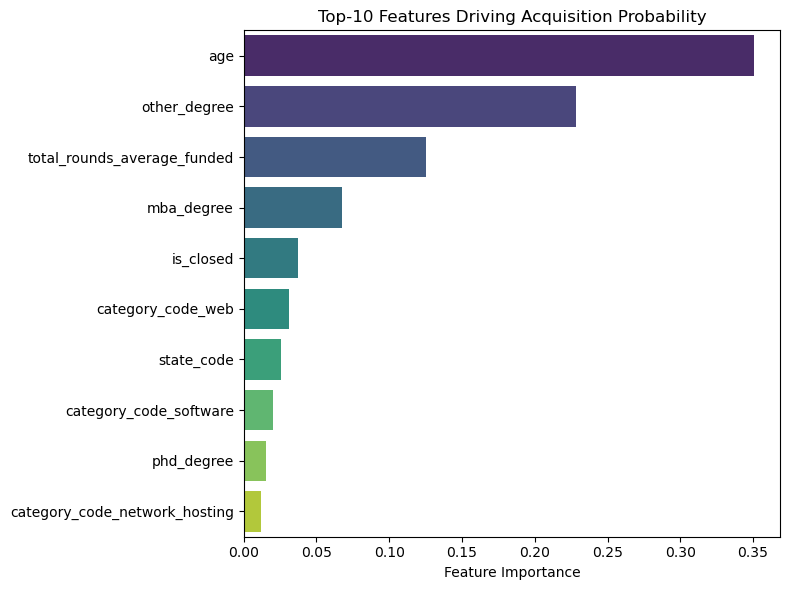

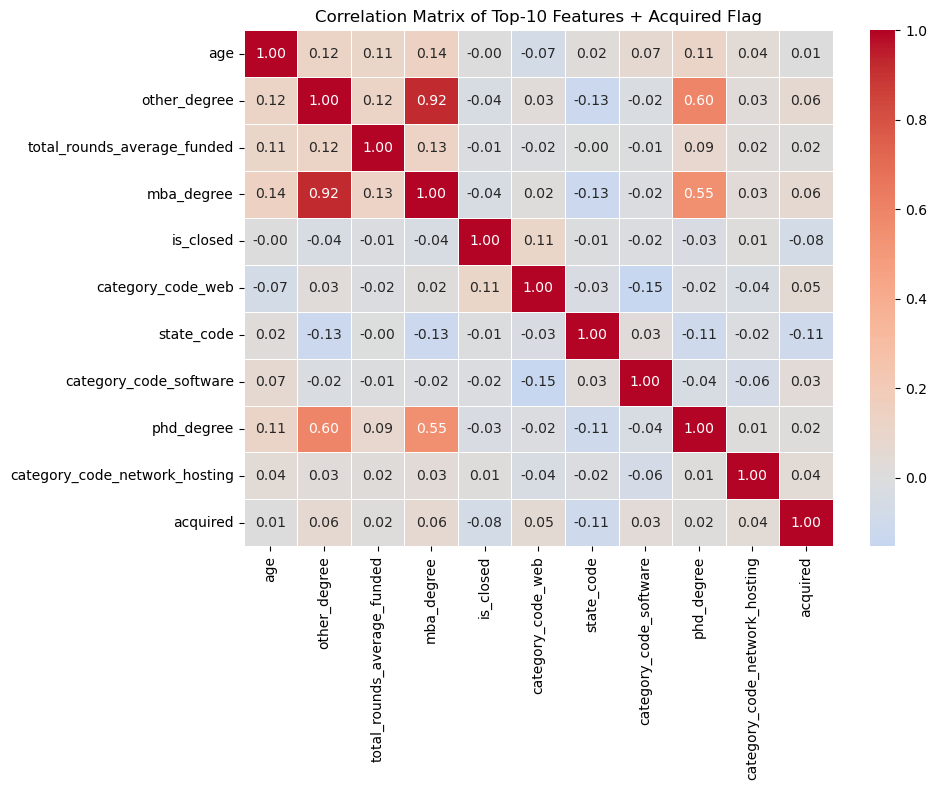

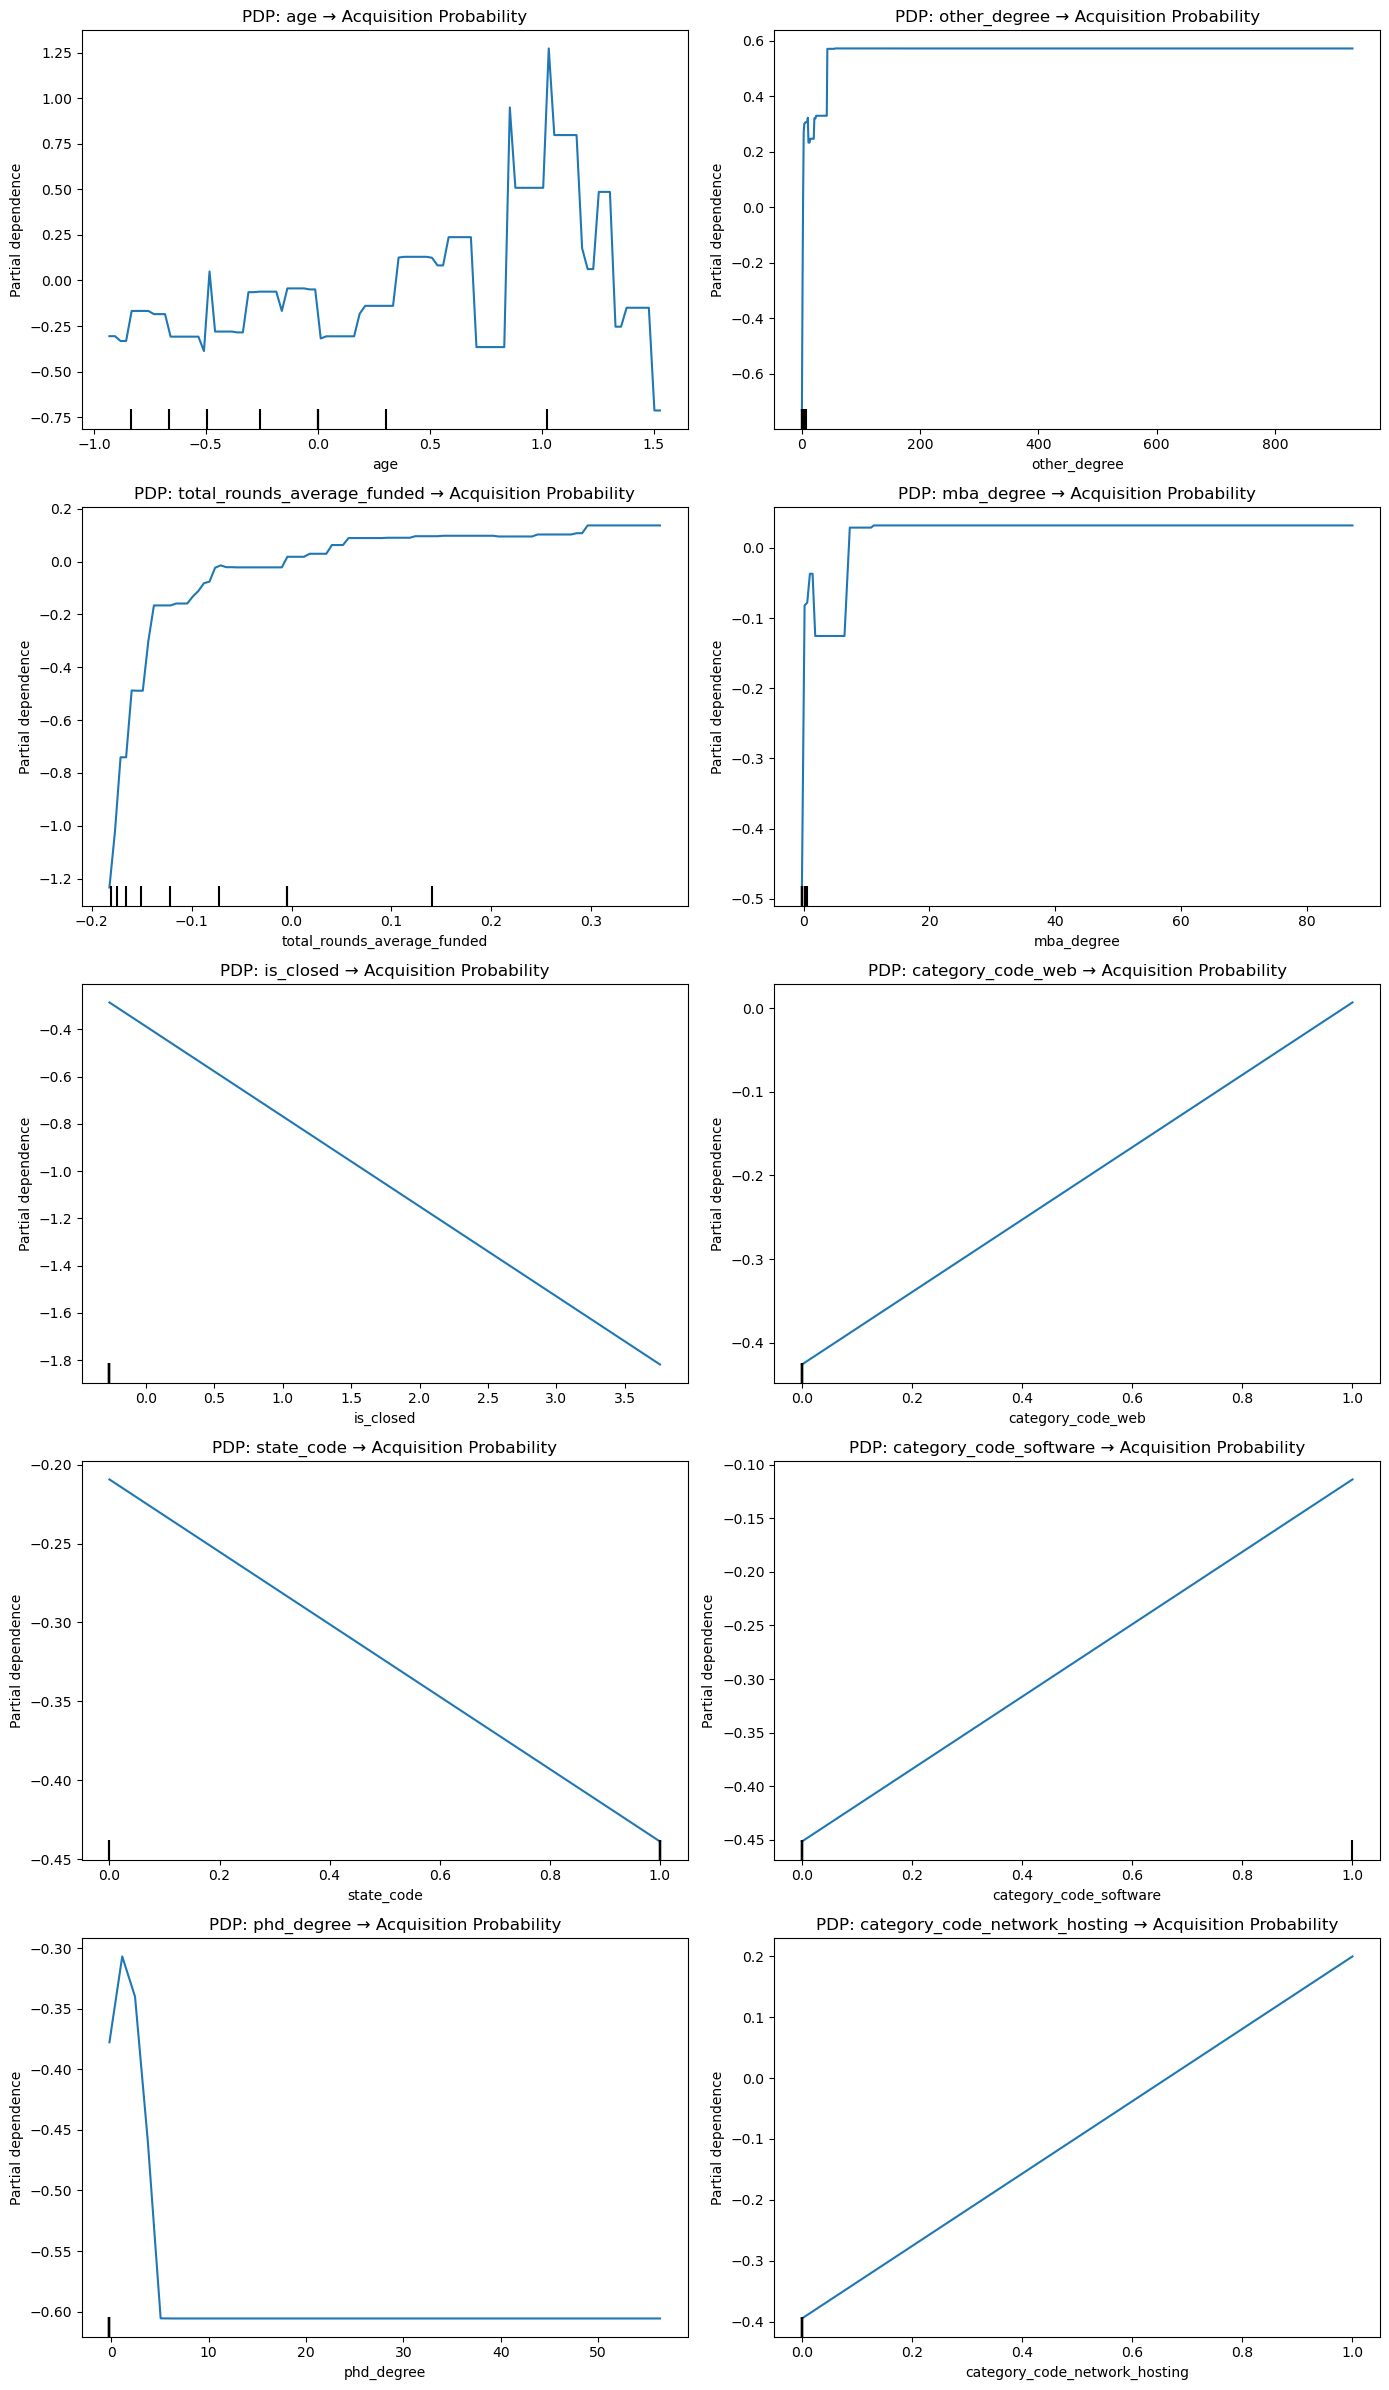

In [10]:
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn_pandas import DataFrameMapper
import os
import matplotlib.pyplot as plt
import seaborn as sns

def path_to_data_file(relpath):
    # turn a relative path into an absolute path
    return os.path.normpath(
        os.path.join(os.path.abspath(os.path.curdir), relpath)
    )

# relative to your project root
DATA_FILE  = path_to_data_file("../data/data.csv")
TRAIN_FILE = path_to_data_file("../data/train_data.csv")
TEST_FILE  = path_to_data_file("../data/test_data.csv")

import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.ensemble import GradientBoostingClassifier
from sklearn_pandas import DataFrameMapper
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.linear_model import RANSACRegressor
from sklearn.preprocessing import LabelBinarizer

# — your helper transformers (as before) —

class ValueImputer(BaseEstimator, TransformerMixin):
    def __init__(self, value, missing_values='NaN', copy=True):
        self.value = value
        self.missing_values = missing_values
        self.copy = copy
    def fit(self, X, y=None): return self
    def transform(self, X):
        mask = self._get_mask(X, self.missing_values)
        X = X.copy() if self.copy else X
        X[mask] = self.value
        return X
    @staticmethod
    def _get_mask(X, value):
        if value == "NaN" or value is None or (isinstance(value, float) and np.isnan(value)):
            return pd.isnull(X)
        else:
            return X == value

class OnceFittedLabelBinarizer(LabelBinarizer):
    def __init__(self, neg_label=0, pos_label=1, sparse_output=False):
        super().__init__(neg_label=neg_label, pos_label=pos_label, sparse_output=sparse_output)
        self.once_fitted = False
    def fit(self, y):
        if self.once_fitted: return self
        self.once_fitted = True
        return super().fit(y)

class FundImputer(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.clf = RANSACRegressor()

    def fit(self, X, y=None):
        frame = pd.DataFrame({'total_rounds':X[:,0],'average_funded':X[:,1]})
        grp   = frame.groupby('total_rounds').average_funded.mean()
        df    = pd.DataFrame({'rounds':grp.index, 'funded':grp.values})
        self.clf.fit(df.rounds.values.reshape(-1,1), df.funded.values.reshape(-1,1))
        return self
    def transform(self, X):
        frame = pd.DataFrame({'total_rounds':X[:,0],'average_funded':X[:,1]})
        mask  = frame.average_funded.isnull()
        # only predict when there's at least one missing
        if mask.any():
            preds = self.clf.predict(
                frame.loc[mask, 'total_rounds']
                     .values.reshape(-1,1)
            ).ravel()
            frame.loc[mask, 'average_funded'] = preds

        return frame.average_funded.values.reshape(-1,1)
    
        pred  = self.clf.predict(frame.loc[mask,'total_rounds'].values.reshape(-1,1)).ravel()
        frame.loc[mask,'average_funded'] = pred
        return frame.average_funded.values.reshape(-1,1)

class ParticipantsImputer(BaseEstimator, TransformerMixin):
    def __init__(self): self.clf = RANSACRegressor()
    def fit(self, X, y=None):
        frame = pd.DataFrame({'average_funded':X[:,0],'average_participants':X[:,1]})
        df    = frame[(frame.average_participants!=0)&frame.average_funded.notnull()]
        self.clf.fit(df.average_funded.values.reshape(-1,1),
                     df.average_participants.values.reshape(-1,1))
        return self
    def transform(self, X):
        frame = pd.DataFrame({'average_funded':X[:,0],'average_participants':X[:,1]})
        mask  = (frame.average_participants==0.0)&frame.average_funded.notnull()
        preds = self.clf.predict(frame.loc[mask,'average_funded'].values.reshape(-1,1)).ravel()
        frame.loc[mask,'average_participants'] = preds
        return frame.average_participants.values.reshape(-1,1)

# — now simplified scorer —

class SimpleAcquisitionScorer:
    def __init__(self):
        # one‐time binarizers
        cat_b  = OnceFittedLabelBinarizer()
        ctry_b = OnceFittedLabelBinarizer()
        st_b   = OnceFittedLabelBinarizer()

        # map all your columns (including ipo & is_closed)
        self.mapper = DataFrameMapper([
            (['category_code'],     [SimpleImputer(strategy="most_frequent"), cat_b]),
            (['country_code'],      [SimpleImputer(strategy="most_frequent"), ctry_b]),
            (['state_code'],        [SimpleImputer(strategy="most_frequent"), st_b]),
            (['mba_degree'],        [ValueImputer(0), StandardScaler()]),
            (['phd_degree'],        [ValueImputer(0), StandardScaler()]),
            (['ms_degree'],         [ValueImputer(0), StandardScaler()]),
            (['other_degree'],      [ValueImputer(0)]),
            (['age'],               [SimpleImputer(), StandardScaler()]),
            (['offices'],           [ValueImputer(1.0), StandardScaler()]),
            (['products_number'],   [ValueImputer(1.0), StandardScaler()]),
            (['total_rounds','average_funded'],
                                     [FundImputer(), StandardScaler()]),
            (['acquired_companies'],[ValueImputer(0)]),
            (['ipo'],               [SimpleImputer(strategy="most_frequent"), StandardScaler()]),
            (['is_closed'],         [SimpleImputer(strategy="most_frequent"), StandardScaler()]),
        ], df_out=True)

        self.pipe = Pipeline([
            ('fill_nan', self.mapper),
            ('clf',      GradientBoostingClassifier())
        ])

    def fit(self, X: pd.DataFrame, y: pd.Series):
        X2 = X.copy()
        X2['ipo']       = X2['ipo'].astype(int)
        X2['is_closed'] = X2['is_closed'].astype(int)

        self.pipe.fit(X2, y)

        # ─── print out top‐10 importances ───────────────────────────
        gb = self.pipe.named_steps['clf']
        feat_names = self.mapper.transformed_names_
        imp = (
            pd.DataFrame({'feature': feat_names, 'importance': gb.feature_importances_})
              .sort_values('importance', ascending=False)
              .reset_index(drop=True)
        )
        print("\nTop 10 features driving acquisition probability:")
        print(imp.head(10).to_string(index=False))
        # ─────────────────────────────────────────────────────────────
        

    def predict_proba(self, X: pd.DataFrame) -> pd.Series:
        X2 = X.copy()
        X2['ipo']       = X2['ipo'].astype(int)
        X2['is_closed'] = X2['is_closed'].astype(int)
        probs = self.pipe.predict_proba(X2)[:,1]
        return pd.Series(probs, index=X.index)
    
    def print_results(self):
        print("Best score: ", self.clf.best_score_)
        print("Best params:", self.clf.best_params_)
        pred = self.clf.predict(self.X_test)
        print("F1:", f1_score(self.Y_test, pred))
        print("Recall:", recall_score(self.Y_test, pred))
        print("Precision:", precision_score(self.Y_test, pred))

        # ---- NEW: feature importances ----
        gb = self.clf.best_estimator_.named_steps['clf']
        # this requires sklearn-pandas ≥0.8.0 for transformed_names_
        feat_names = self.mapper.transformed_names_
        imp = pd.DataFrame({
            'feature': feat_names,
            'importance': gb.feature_importances_
        }).sort_values('importance', ascending=False)
        print("\nTop 10 features driving acquisition probability:")
        print(imp.head(10).to_string(index=False))



# — example usage —

if __name__ == '__main__':
    import pandas as pd
    import matplotlib.pyplot as plt
    import seaborn as sns
    from sklearn.inspection import PartialDependenceDisplay

    # ─── 1) Load & split ────────────────────────────────────────────────
    train = pd.read_csv("../data/train_data.csv")
    test  = pd.read_csv("../data/test_data.csv")

    X_train = train.drop(['company_id','is_acquired'], axis=1)
    y_train = train['is_acquired']
    X_test  = test .drop(['company_id','is_acquired'], axis=1)
    y_test  = test ['is_acquired']

    # ─── 2) Fit your scorer & print top-10 importances ────────────────
    scorer = SimpleAcquisitionScorer()
    scorer.fit(X_train, y_train)

    # Also grab the raw feature importances & names:
    gb         = scorer.pipe.named_steps['clf']
    feat_names = scorer.mapper.transformed_names_
    imp_df     = (
        pd.DataFrame({
            'feature':    feat_names,
            'importance': gb.feature_importances_
        })
        .sort_values('importance', ascending=False)
        .reset_index(drop=True)
    )
    top10_features = imp_df['feature'].iloc[:10].tolist()

    # ─── 3) Bar chart of Top-10 importances ────────────────────────────
    plt.figure(figsize=(8,6))
    sns.barplot(
        data=imp_df.iloc[:10],
        x='importance',
        y='feature',
        palette='viridis'
    )
    plt.title("Top-10 Features Driving Acquisition Probability")
    plt.xlabel("Feature Importance")
    plt.ylabel("")
    plt.tight_layout()
    plt.show()

    # ─── 4) Build transformed X (cast flags → int, then mapper) ────────
    X2 = X_train.copy()
    X2['ipo']       = X2['ipo'].astype(int)
    X2['is_closed'] = X2['is_closed'].astype(int)

    # this yields a DataFrame with your exact transformed columns
    X_trans = scorer.mapper.transform(X2)

    # ─── 5) Heatmap of correlations between Top-10 & target ────────────
    df_corr = (
        pd.concat([X_trans[top10_features], y_train.rename('acquired')], axis=1)
          .corr()
    )
    plt.figure(figsize=(10,8))
    sns.heatmap(
        df_corr,
        annot=True,
        fmt=".2f",
        cmap="coolwarm",
        center=0,
        linewidths=0.5
    )
    plt.title("Correlation Matrix of Top-10 Features + Acquired Flag")
    plt.tight_layout()
    plt.show()

    # ─── 6) Partial‐dependence plots for each Top-10 feature ───────────
    clf = scorer.pipe.named_steps['clf']   # your fitted GBM

    fig, axes = plt.subplots(5, 2, figsize=(14,24))
    for feat, ax in zip(top10_features, axes.ravel()):
        PartialDependenceDisplay.from_estimator(
            estimator     = clf,
            X             = X_trans,
            features      = [feat],
            feature_names = X_trans.columns,
            ax            = ax
        )
        ax.set_title(f"PDP: {feat} → Acquisition Probability")
    plt.tight_layout()
    plt.show()


# Key Feature Effects (with Definitions)

Each entry below shows the variable’s meaning and how its Partial Dependence curve shifts acquisition probability.

---

### `age`  
_Company lifespan in days_  
- **Below 0** (younger than average): slight negative lift → very young startups less attractive  
- **0 → +1 SD**: lift rises steadily (up to ~+1.2) → mid‐age firms most likely  
- **Above +1 SD**: effect tapers off  

---

### `other_degree`  
_Count of non‐MBA/PhD degrees_  
- **0 → ~20**: big positive jump (up to +0.6) → a few “other” credentials strongly boost odds  
- **>200**: plateaus → additional “other” degrees no longer add lift  

---

### `total_rounds_average_funded`  
_Average funding per round (scaled)_  
- **Below mean**: heavy negative lift (down to –1.2) → under‐funded firms unlikely targets  
- **Above mean**: climbs to modest positive (~+0.15) → well‐capitalized firms more attractive  

---

### `mba_degree`  
_Count of MBA holders_  
- **0 → ~10**: lift from –0.5 up to ~+0.05 → having a handful of MBAs helps  
- **>10**: flattens → beyond that, little extra benefit  

---

### `is_closed`  
_Operating status (0=open, 1=closed)_  
- **0 (open)**: moderate lift (~–0.4)  
- **1 (closed)**: deep negative (–1.8) → closed firms almost never get acquired  

---

### `category_code_web`  
_Binary flag: “web” category_  
- **0**: –0.45  
- **1**: ~0.00 → web firms get a small positive bump  

---

### `state_code`  
_Binary flag: primary state bucket_  
- **0**: –0.20  
- **1**: –0.45 → being in the “main” state actually reduces odds  

---

### `category_code_software`  
_Binary flag: “software” category_  
- **0**: –0.45  
- **1**: –0.11 → software firms enjoy a noticeable boost  

---

### `phd_degree`  
_Count of PhD holders_  
- **0–5**: improves lift (to ~–0.30) → a few PhDs help  
- **>5**: drops toward –0.60 → too many PhDs shows diminishing returns  

---

### `category_code_network_hosting`  
_Binary flag: “network_hosting” category_  
- **0**: –0.40  
- **1**: +0.20 → one of the largest positive lifts  

---


In [ ]:
# 1) After training your scorer…
scorer = SimpleAcquisitionScorer()
scorer.fit(X_train, y_train)

# 2) Define a helper to score one company
def score_company(feat_dict: dict) -> float:
    """
    feat_dict must have exactly the same feature keys as  training X,
    e.g. {
       'category_code': 'software',
       'country_code': 'USA',
       'state_code': 'CA',
       'mba_degree': 3,
       'phd_degree': 1,
       'ms_degree': 0,
       'other_degree': 5,
       'age': 1500,
       'offices': 2,
       'products_number': 4,
       'total_rounds': 2,
       'average_funded': 2000000,
       'acquired_companies': 0,
       'ipo': False,
       'is_closed': False
    }
    """
    # turn into a single-row DataFrame
    df = pd.DataFrame([feat_dict])
    # ensure bools are ints for your mapper
    df['ipo']       = df['ipo'].astype(int)
    df['is_closed'] = df['is_closed'].astype(int)
    # call your pipeline
    prob_series = scorer.predict_proba(df)
    # return the 0→1 probability for “acquired”
    return prob_series.iloc[0]

# 3) Example usage:
new_co = {
   'category_code': 'software',
   'country_code': 'USA',
   'state_code': 'CA',
   'mba_degree': 3,
   'phd_degree': 1,
   'ms_degree': 0,
   'other_degree': 5,
   'age': 1500,
   'offices': 2,
   'products_number': 4,
   'total_rounds': 2,
   'average_funded': 2_000_000,
   'acquired_companies': 0,
   'ipo': False,
   'is_closed': False
}

prob = score_company(new_co)
print(f" Acquisition probability: {prob:.1%}")


/Users/yuxing/miniforge3/envs/dsc80/lib/python3.12/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function tosequence is deprecated; tosequence was deprecated in 1.5 and will be removed in 1.7
  warnings.warn(msg, category=FutureWarning)



Top 10 features driving acquisition probability:
                      feature  importance
                          age    0.336441
                 other_degree    0.228811
  total_rounds_average_funded    0.132314
                   mba_degree    0.068376
                    is_closed    0.037622
            category_code_web    0.033733
                   state_code    0.026303
       category_code_software    0.020835
                   phd_degree    0.015372
category_code_network_hosting    0.010956
🔮 Acquisition probability: 21.5%


In [13]:
def analyze_takeover(scorer, X_new, dcf_func, dcf_kwargs, syn_kwargs):
    """
    scorer      : your SimpleAcquisitionScorer(), already .fit(...)
    X_new       : 1-row DataFrame of the target’s features
    dcf_func    : your valuator_multi_phase function
    dcf_kwargs  : dict of inputs for the baseline DCF
    syn_kwargs  : dict of inputs for the synergy DCF
    """
    # 1) DCF valuations
    base_res = dcf_func(**dcf_kwargs)
    syn_res  = dcf_func(**syn_kwargs)
    V_base   = base_res['equity_value']     # $143.34
    V_syn    = syn_res['equity_value']      # $176.25

    # 2) Acquisition probability
    P = scorer.predict_proba(X_new)[0]

    # 3) Expected take-under value
    EV = (1 - P)*V_base + P*V_syn

    return {
      'P_acquired':       P,
      'V_baseline':       V_base,
      'V_synergies':      V_syn,
      'E_value':          EV,
      'MoS_baseline':    (V_base  - X_new['current_price'].iloc[0]) / X_new['current_price'].iloc[0],
      'MoS_synergies':   (V_syn   - X_new['current_price'].iloc[0]) / X_new['current_price'].iloc[0],
      'MoS_expected':    (EV      - X_new['current_price'].iloc[0]) / X_new['current_price'].iloc[0],
    }

# — usage example —
if __name__=='__main__':
    # 1) prepare your ML scorer and DCF inputs…
    scorer.fit(X_train, y_train)

    dcf_base_args = {
      'risk_free_rate': …,
      'ERP': …,
      # … all your other valuator_multi_phase args for baseline …
    }
    dcf_syn_args = {
      **dcf_base_args,
      # tweak one or two inputs to reflect synergies, e.g. higher terminal margin:
      'terminal_operating_margin': 0.20,
      'additional_return_on_cost_of_capital_in_perpetuity': 0.02,
      # …etc…
    }

    # 2) pick a “new” company (1-row DataFrame) with same features + current_price
    X_new = pd.DataFrame([{
      'category_code': 'software',
      'country_code':  'USA',
      # …
      'is_closed': False,
      'current_price': 210.00
    }])

    # 3) run the combined analysis
    report = analyze_takeover(
      scorer, X_new,
      valuator_multi_phase, dcf_base_args, dcf_syn_args
    )

    for k,v in report.items():
        if k.startswith('P_'):    print(f"{k}: {v:.1%}")
        elif k.startswith('V_') or k=='E_value':
            print(f"{k}: ${v:,.2f}")
        else:
            print(f"{k}: {v:+.1%}")


SyntaxError: invalid character '…' (U+2026) (3854006029.py, line 37)